In [533]:
import re
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

from sklearn import model_selection

from sklearn.metrics import confusion_matrix

%matplotlib inline 

### Global variables

In [534]:
random_state = 100
n_jobs = 6
#n_jobs = 2
cv = 5
scoring = 'neg_mean_absolute_error'

### Load data

In [535]:
train_df = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
print('Train data shape: ', train_df.shape)

test_df = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')
print('Test data shape: ', test_df.shape)

Train data shape:  (1460, 81)
Test data shape:  (1459, 80)


In [536]:
y_train = train_df['SalePrice']

train_df.drop(['SalePrice'], axis=1, inplace=True)

unmodified_train_df = train_df

train_df.shape

(1460, 80)

In [537]:
all_df = pd.concat([train_df, test_df])

all_df.shape

(2919, 80)

### Handle columns with nulls

In [538]:
train_df.isnull().sum()[train_df.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [539]:
test_df.isnull().sum()[test_df.isnull().sum() > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [540]:
# numeric features

numeric_features_fill_mean = [ 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                             'TotalBsmtSF', 'GarageArea']

for feature in numeric_features_fill_mean:
    all_df[feature]=all_df[feature].fillna(all_df[feature].mean())

In [541]:
numeric_features_fill_mode = ['GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars']

for feature in numeric_features_fill_mode:
    all_df[feature]=all_df[feature].fillna(all_df[feature].mode()[0])

In [542]:
# categorical features

categorical_features_fill_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
                                 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
                                  'MiscFeature']

for feature in categorical_features_fill_none:
    all_df[feature]=all_df[feature].fillna('None')

In [543]:
categorical_features_fill_mode = ['Electrical', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd',
                                 'KitchenQual', 'Functional', 'SaleType']

for feature in categorical_features_fill_mode:
    all_df[feature]=all_df[feature].fillna(all_df[feature].mode()[0])

In [544]:
test_id = test_df['Id']

train_df.drop(['Id'],axis=1,inplace=True)
test_df.drop(['Id'],axis=1,inplace=True)
all_df.drop(['Id'],axis=1,inplace=True)

non_linear_train_df = all_df.iloc[:train_df.shape[0],:].copy()
non_linear_test_df = all_df.iloc[train_df.shape[0]:,:].copy()

In [545]:
print('Train data shape: ', train_df.shape)
print('Test data shape: ', test_df.shape)
print('All df data shape: ', all_df.shape)
print('Non-linear train df data shape: ', non_linear_train_df.shape)
print('Non-linear test df data shape: ', non_linear_test_df.shape)

Train data shape:  (1460, 79)
Test data shape:  (1459, 79)
All df data shape:  (2919, 79)
Non-linear train df data shape:  (1460, 79)
Non-linear test df data shape:  (1459, 79)


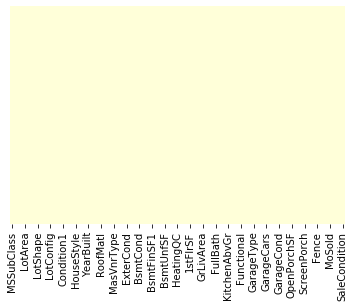

In [546]:
sns.heatmap(all_df.isnull(), yticklabels=False, cbar=False, cmap='YlGnBu')

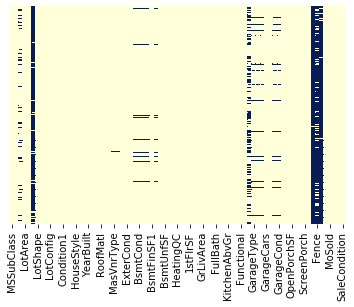

In [547]:
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap='YlGnBu')

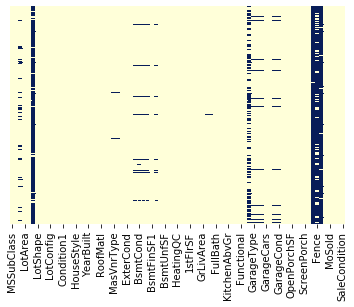

In [548]:
sns.heatmap(test_df.isnull(), yticklabels=False, cbar=False, cmap='YlGnBu')

### Non-dummified dataset

In [549]:
categorical_features = [ 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
                        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
                        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
                        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

In [550]:
unmodified_train_df = non_linear_train_df.copy()

In [551]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

In [552]:
for col in categorical_features:
    non_linear_train_df[col] = ord_enc.fit_transform(non_linear_train_df[[col]]) 

In [553]:
for col in categorical_features:
    non_linear_test_df[col] = ord_enc.fit_transform(non_linear_test_df[[col]]) 

In [554]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()

In [555]:
non_linear_train_df = pd.DataFrame(scaler.fit_transform(non_linear_train_df), columns=non_linear_train_df.columns)

/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


### Outlier

In [560]:
train_df.columns.drop(categorical_features)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [562]:
from scipy import stats

for col in train_df.columns.drop(categorical_features):
    train_col_score = ((non_linear_train_df[col] - non_linear_train_df[col].mean()) / non_linear_train_df[col].std()).abs() > 3
    #print(train_col_score)    
    if train_col_score.any():
        test_col_score = ((non_linear_test_df[col] - non_linear_test_df[col].mean()) / non_linear_test_df[col].std()).abs() > 3
        if test_col_score.any():
            print(col)

LotFrontage
LotArea
OverallQual
OverallCond
TotalBsmtSF
1stFlrSF
LowQualFinSF
GrLivArea
BsmtHalfBath
FullBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
GarageCars
GarageArea
3SsnPorch
ScreenPorch
PoolArea
MiscVal


### EDA

#### Correlation

In [474]:
features = non_linear_train_df.corrwith(y_train).abs().sort_values(ascending=False)[:10].index

non_linear_train_df.corrwith(y_train).abs().sort_values(ascending=False)[:10]

OverallQual    0.780396
GrLivArea      0.695363
GarageCars     0.653808
ExterQual      0.619172
GarageArea     0.608821
TotalBsmtSF    0.601455
1stFlrSF       0.588290
BsmtQual       0.576642
KitchenQual    0.573339
YearBuilt      0.560657
dtype: float64

/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


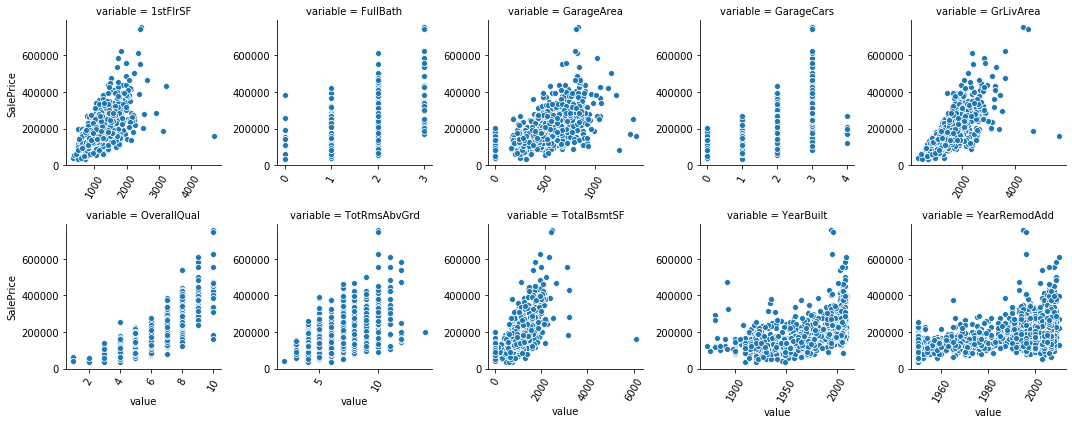

In [464]:
temp_df = unmodified_train_df[features]
temp_df['SalePrice'] = y_train

f = pd.melt(temp_df, id_vars=['SalePrice'], value_vars=sorted(features))
g = sns.FacetGrid(f, col='variable', col_wrap=5, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.scatterplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

#### OLS

In [470]:
import statsmodels.api as sm

const_df = sm.add_constant(np.asarray(non_linear_train_df))
est = sm.OLS(y_train, const_df)
est2 = est.fit()
#print(est2.summary())

In [471]:
p_vals = est2.pvalues.abs().sort_values(ascending=True)[:10]
features = []

for index in p_vals.index:
    i = int(index.replace("x", "").replace("const", "0"))
    features.append(non_linear_train_df.columns[i])
    print(non_linear_train_df.columns[i], p_vals[index])

MSSubClass 0.0
Exterior1st 1.1120722801676795e-24
OverallCond 5.539114191611192e-19
Heating 3.1312398167665627e-10
RoofMatl 3.07861214872277e-08
BsmtUnfSF 1.9922280575525387e-07
BsmtFinSF2 6.657031858720217e-07
Street 1.1794090766867754e-06
YearBuilt 3.0166924128928327e-06
TotRmsAbvGrd 3.846308772878868e-06


/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


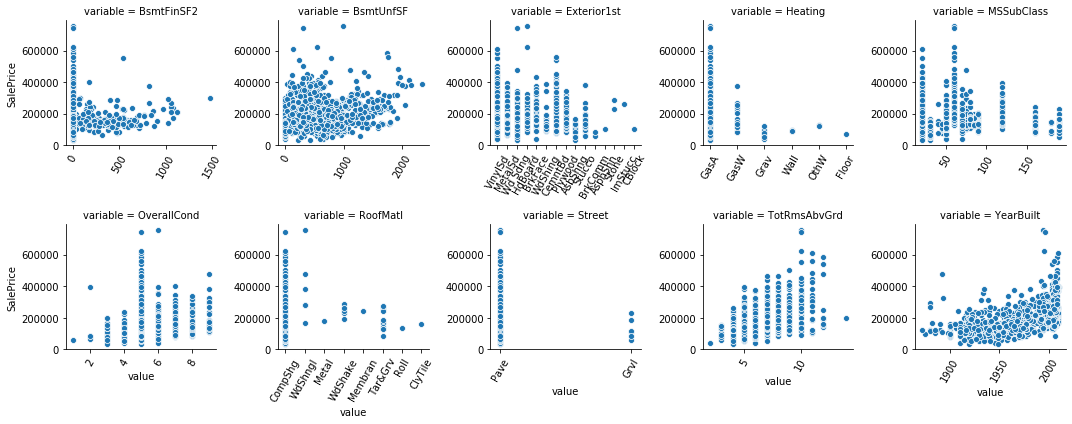

In [472]:
temp_df = unmodified_train_df[features]
temp_df['SalePrice'] = y_train

f = pd.melt(temp_df, id_vars=['SalePrice'], value_vars=sorted(features))
g = sns.FacetGrid(f, col='variable', col_wrap=5, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.scatterplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

#### F_regression

In [468]:
from sklearn.feature_selection import f_regression

f_vals = pd.Series(f_regression(non_linear_train_df, y_train)[0])
indexes = f_vals.abs().sort_values(ascending=False).index[:10]

for index in indexes:
    print(non_linear_train_df.columns[index], f_vals[index])

OverallQual 2271.0780368701903
GrLivArea 1365.010950081361
GarageCars 1088.5694307452584
ExterQual 906.4799222610907
GarageArea 858.7227380944764
TotalBsmtSF 826.3631809349223
1stFlrSF 771.6465390047797
BsmtQual 726.3212857083082
KitchenQual 713.9638528517589
YearBuilt 668.4066491732336


/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


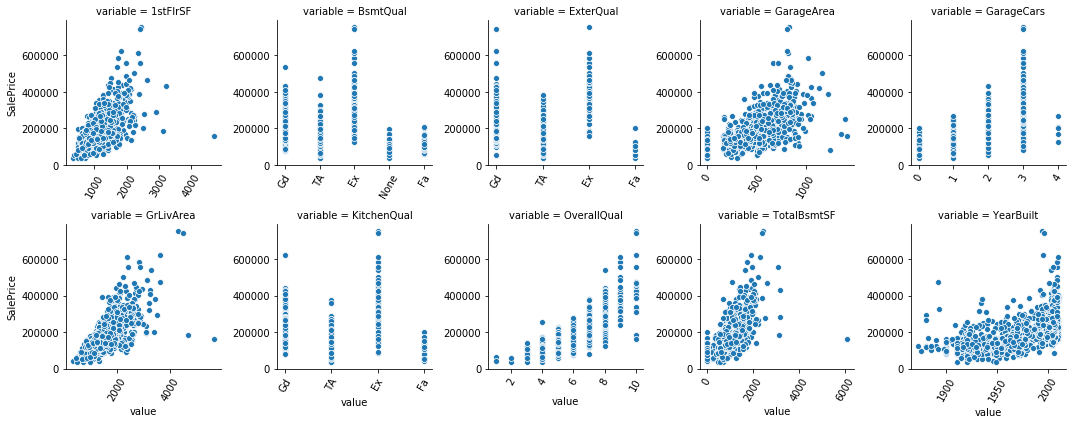

In [469]:
features = non_linear_train_df.columns[indexes]
temp_df = unmodified_train_df[features]
temp_df['SalePrice'] = y_train

f = pd.melt(temp_df, id_vars=['SalePrice'], value_vars=sorted(features))
g = sns.FacetGrid(f, col='variable', col_wrap=5, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.scatterplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

#### SelectKBest

In [500]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

fs = SelectKBest(score_func=f_regression, k=10)
#fs = SelectKBest(score_func=mutual_info_regression, k=10)

fs.fit_transform(non_linear_train_df, y_train)

mask = fs.get_support()

In [501]:
pd.Series(fs.scores_).sort_values(ascending=False)[:10]

16    2271.078037
45    1365.010950
60    1088.569431
26     906.479922
61     858.722738
37     826.363181
42     771.646539
29     726.321286
52     713.963853
18     668.406649
dtype: float64

In [502]:
features = []

for bool, feature in zip(mask, non_linear_train_df.columns):
    if bool:
        features.append(feature) 
        
features

['OverallQual',
 'YearBuilt',
 'ExterQual',
 'BsmtQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'KitchenQual',
 'GarageCars',
 'GarageArea']

/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


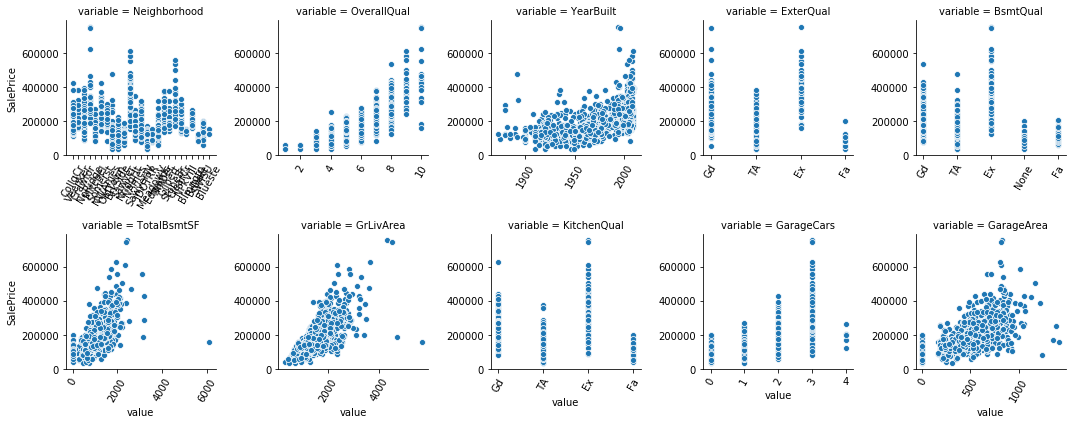

In [497]:
temp_df = unmodified_train_df[features]
temp_df['SalePrice'] = y_train
#print(temp_df.head(5))

f = pd.melt(temp_df, id_vars=['SalePrice'])
g = sns.FacetGrid(f, col='variable', col_wrap=5, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.scatterplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

### Sale Price

Text(0.5, 0, 'Sale Price')

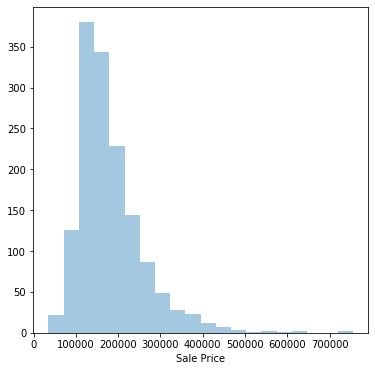

In [410]:
# SalePrice - Sale Price

fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot(y_train, norm_hist=False, kde=False, bins=20)

ax.set_xlabel('Sale Price')

Text(0.5, 0, 'Sale Price')

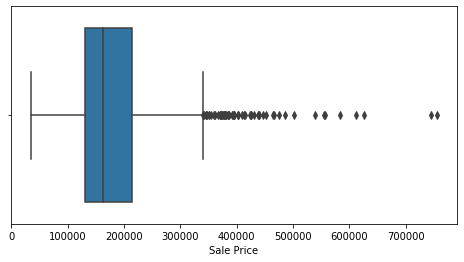

In [87]:
# SalePrice - Sale Price

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(y_train, ax=ax)

ax.set_xlabel('Sale Price')

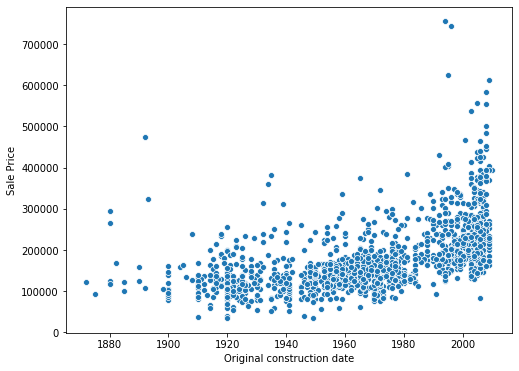

In [70]:
# YearBuilt - Original construction date

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(train_df['YearBuilt'], y_train, ax=ax, marker='o')

ax.set_xlabel('Original construction date')
ax.set_ylabel('Sale Price')

plt.show()

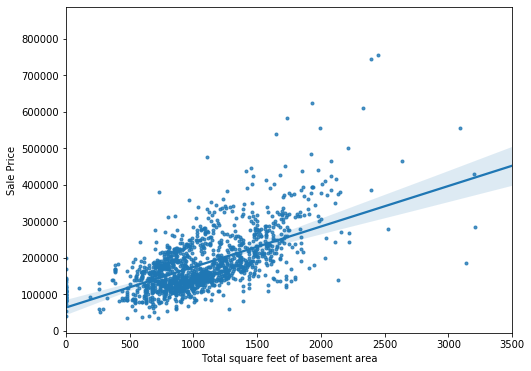

In [64]:
# TotalBsmtSF - Total square feet of basement area

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train_df['TotalBsmtSF'], y_train, ax=ax, marker='.')

ax.set(xlim=(0, 3500))
ax.set_xlabel('Total square feet of basement area')
ax.set_ylabel('Sale Price')

plt.show()

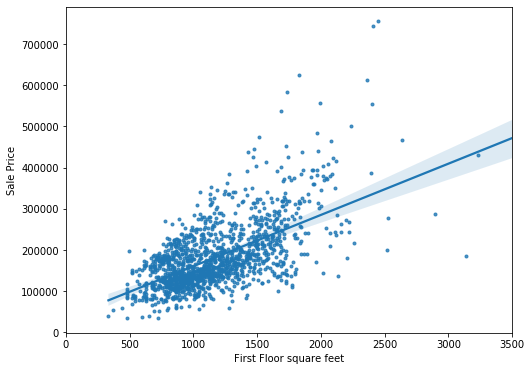

In [65]:
# 1stFlrSF - First Floor square feet

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train_df['1stFlrSF'], y_train, ax=ax, marker='.')

ax.set(xlim=(0, 3500))
ax.set_xlabel('First Floor square feet')
ax.set_ylabel('Sale Price')

plt.show()

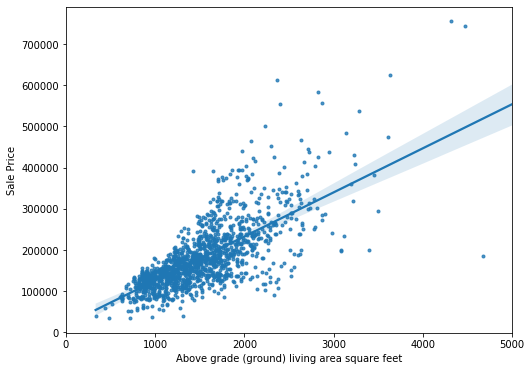

In [67]:
# GrLivArea - Above grade (ground) living area square feet

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train_df['GrLivArea'], y_train, ax=ax, marker='.')

ax.set(xlim=(0, 5000))
ax.set_xlabel('Above grade (ground) living area square feet')
ax.set_ylabel('Sale Price')

plt.show()

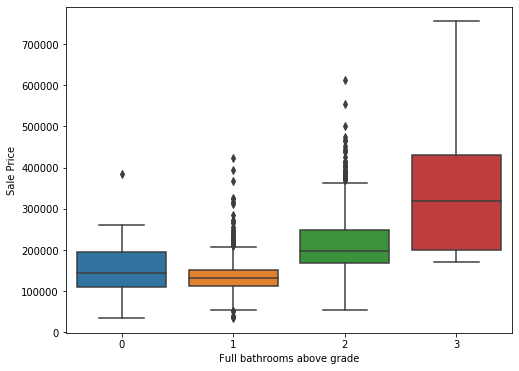

In [51]:
# FullBath - Full bathrooms above grade

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['FullBath'], y_train, ax=ax)

ax.set_xlabel('Full bathrooms above grade')
ax.set_ylabel('Sale Price')

plt.show()

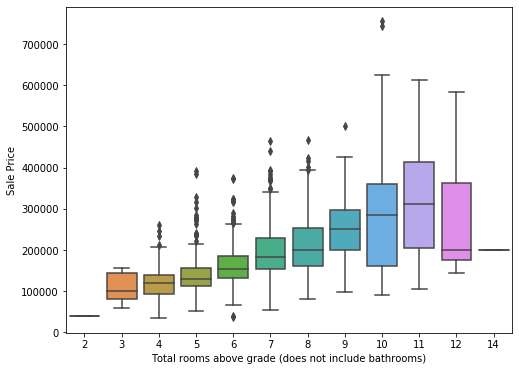

In [52]:
# TotRmsAbvGrd - Total rooms above grade (does not include bathrooms)

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['TotRmsAbvGrd'], y_train, ax=ax)

ax.set_xlabel('Total rooms above grade (does not include bathrooms)')
ax.set_ylabel('Sale Price')

plt.show()

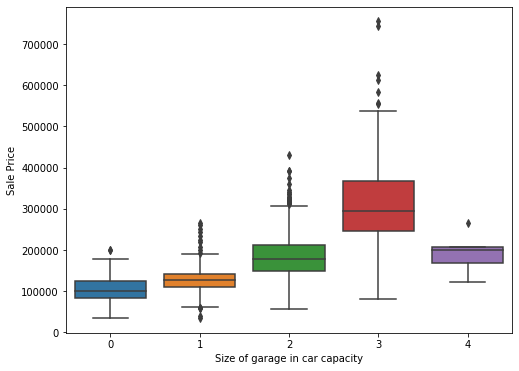

In [53]:
# GarageCars - Size of garage in car capacity

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['GarageCars'], y_train, ax=ax)

ax.set_xlabel('Size of garage in car capacity')
ax.set_ylabel('Sale Price')

plt.show()

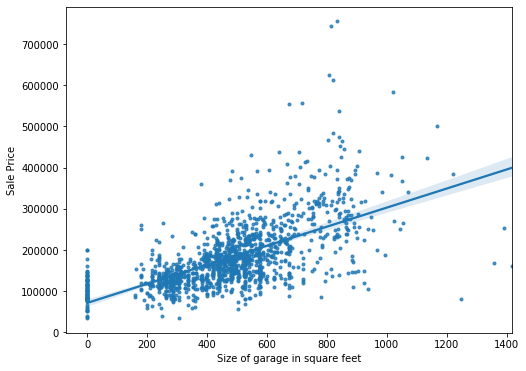

In [71]:
# GarageArea - Size of garage in square feet

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train_df['GarageArea'], y_train, ax=ax, marker='.')

ax.set_xlabel('Size of garage in square feet')
ax.set_ylabel('Sale Price')

plt.show()

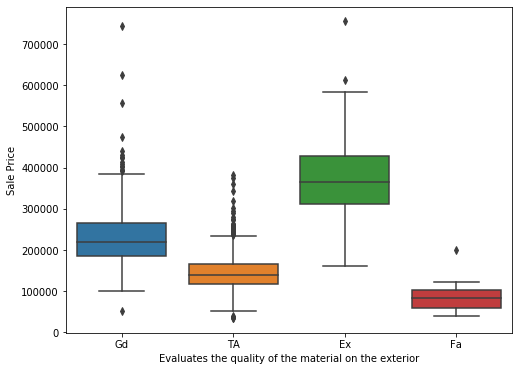

In [55]:
# ExterQual - Evaluates the quality of the material on the exterior

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['ExterQual'], y_train, ax=ax)

ax.set_xlabel('Evaluates the quality of the material on the exterior')
ax.set_ylabel('Sale Price')

plt.show()

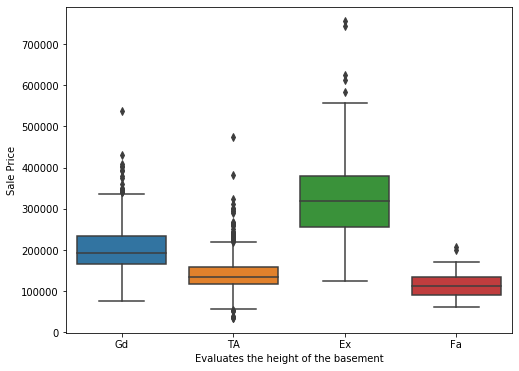

In [56]:
# BsmtQual - Evaluates the height of the basement

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['BsmtQual'], y_train, ax=ax)

ax.set_xlabel('Evaluates the height of the basement')
ax.set_ylabel('Sale Price')

plt.show()

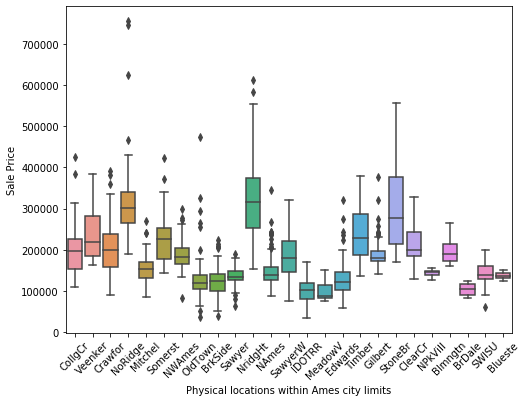

In [90]:
# Neighborhood - Physical locations within Ames city limits

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['Neighborhood'], y_train, ax=ax)

ax.set_xlabel('Physical locations within Ames city limits')
ax.set_ylabel('Sale Price')
plt.xticks(rotation=45)

plt.show()

### Outliers

In [511]:
train_df = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
print('Train data shape: ', train_df.shape)

test_df = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')
print('Test data shape: ', test_df.shape)

Train data shape:  (1460, 81)
Test data shape:  (1459, 80)


In [512]:
train_df.drop(['SalePrice'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)
train_df.drop(['Id'], axis=1, inplace=True)

In [515]:
from scipy import stats

for col in train_df.columns:
    train_col_score = ((train_df[col] - train_df[col].mean()) / train_df[col].std()).abs() > 2
    print(train_col_score)    
    if train_col_score.any():
        test_col_score = ((test_df[col] - test_df[col].mean()) / test_df[col].std()).abs() > 2
        if test_col_score.any():
            print(col)
        

0       False
1       False
2       False
3       False
4       False
        ...  
1455    False
1456    False
1457    False
1458    False
1459    False
Name: MSSubClass, Length: 1460, dtype: bool
MSSubClass


TypeError: Could not convert RLRLRLRLRLRLRLRLRMRLRLRLRLRLRLRMRLRLRLRLRLRMRLRMRLRLRLRLRLRMC (all)RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLFVRMRLRLRMRMRLRLRLFVRLRLRLRLRMRLRMRLRLRLRLRMRLRLRLRLRLRMRMRLRMRLRMRLRMRLRLRLRLRLFVC (all)RLRLRLRLC (all)RLRLRLRLRLRLRLRLRLRLRMFVRMRMRMRLRLRLRLRLRLFVRLRLRLRLRLRMRLRLRLRMRLRMRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRMRMRMRLRLRMRLRLRLRLRMRLRLRLFVRLRLRLRLRLRMRLRLRLRLRLRMRLRLRLRLRLRLRLRLRMFVRLRLRMRLRMRLRLRLRLRLRLRLRMRLRLRLRLRMRLRMRLRLRMRMRLRLRLRLRLRLRLFVRLRLRLRLRMRLRLRLRLRLRLRLRMRLRMRLRLRLRLRMRLRLRMRLRLRLRLFVRMRMRLRLRLRMRLRLRLRLRMRLRLRLRLFVRLRLRMRLRLRLRMRMRLRLRLRMRLFVRLRLRLRLRLRLRLRLRLRLFVRLRLRLFVRLRLRLRLRLRLRLRLRLRLRMFVRLRLRLRLRLRLRMRLRLRMRLRLRLRLRMRLRMRLRLFVRLRLRLRLRLRMRLRMRLRLRLRMRLRLRLRMRLRLRLRLRLRLRLRHRLRLRMRLRLRLRLRLRLRLRLRMRLRLRLRMRLRLRLRLRLRMRLRMRLRLRLRLRLRLRLRLRLRLRLFVRLRLRLFVRLRHRLRLRLRLRLRLRLRLRLRLRLRLRLRLRMFVRLRLRLRLRLRLRLRLRLFVRLRLFVRMRLRLRLRLRLRLRMRLRLRLRLRMRLRLRLRLRMRMRMRLRMRLRMRMRLRLRLRLRMRLRLRLRLRLRMRMRMRLRLFVRLRLRMRLRMRLFVRLRLRLRLRMRLRLRLRLRLRLRMRLRLRLRLRLRLRMRLRLRMRMRLRLRLRLRLRMRMRLRLRLRMC (all)RLRLRLRLRMFVRLRLRLRMRLFVRMRLRLRLRLRLRLRLRLRLRLRLRLRLRMRLRLFVRLRLRLRLRLRMRLRLRLRLRLRLRLRLRLRLRLRHRLRLRLRLRMFVRLRMRLRLRLRMRLC (all)RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLFVRMRLRLRLRMRMRLRLRLRLRMRLRLRLRMRLRLRMRLRLRMRLRMRLFVRLRLRLRLRLRLRLRLRLRLRMRLRLRLRLRLRLRLRLFVRLRLRLRLRLRLRMRLRLRLRLRHRMRMRLRLRLFVRLRLFVRLRLRLRLRMFVRLRLRMRLRMRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRHRLRLRLRLRMRLRLRLRLRHRLRLRLRLFVFVRLRLRMRLRLRLRMRLRMRLRLFVRLRLRLRMRLRMRLRLRLRLRLC (all)RLRLRLRLRMRLRLRLRLRMRLRLRLRLRLRLRLRMRLRLRLRLRLRMRLRLRLRLRMRLRLRLRLRLRLRMRLRLRMRLRLRLRLFVRLRLFVRLRLRMFVRLRLRLRLRLRLRLRLRLRLRLRLRMRLRLRHRLRLRLRLRLRMRLRMRLRMRLRLRLRLRLRLRLRLRLRLRLRLRMRLRLRLRLRLRLRLRMRLRMC (all)RLRLRLRLRLRLRLRLRMRLRLFVRLRMRLRLFVRLFVRLRLRLRLRMRMRLRLRHRMRLRLRMRLRLRLRLRLRMRLRLRLRLRLRLRLRLRLRLRLRLRLFVRLRLRLRLRLRLRLRLRLRMFVRLRLRLRLRLRLRLRLRLFVRLRLRLRLRLRLRLRLRLRLRMRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRMRHFVRMC (all)RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRMRLRLRLRLRLRHRLRLRLRHRMRLRLFVRLRLRLRLRLRLRLRLRMRLRLRLRLFVRLFVRLFVRLRLRLRLRLRLRLRLRMRLRLFVRLRMRLRLRLRLRLRLRMRLRLRLRLRLRLRLRLRMRLRLRLRLRLRMRLRLRLRLRLRLRLRLRMRLRLRLRLRLRLRMRHRLRLRLRLRLRLRLRMRMRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLC (all)RMRMRLRLRLRLRMRLRLRLRLRLRLRLRLRLRMRLRLRLRLRLRLRLRMFVRMFVRLFVRLRLRLRLRMRLRMRLRLRLRLRLRMRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRMRLRLRLRLRLRLRLRLRMRLRLRMRLRLRMRLRLRLRLRLRLRLRLRLRMRLRLRMRMRLRLRLRMRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLFVRLRLRLRLRMRLRLRLRMRLRLRLRLRLRLRLRLRLFVRMRMRLRLRLRMRLRLRLRLRMRLRLRLRHRLRLRLRLRLRLRLRLRLRMFVRMRMRLRLRLRLRLRLRLRLRLRLRLRLRLRLRHRLRLRLRLRLRLRLRLRLRLRLFVRLRMRLRLRLRLRLRLRMRLRLRLRLRLRLRLRLRHFVRMRLRLRLRLRLRLRLRLRLRLRLRLC (all)RLRLRLRLRLRMRLRLRLRLRLRMRMRLRLRLRLRMRLRLRLRLRLRLRMRLRLRLRMRLRLRLRLRLRLRLRLFVRLRLRLRLRLRLRLRMRHRLRMRLRLRLRLRMRMRLRLRMRLRLRLRLRLRLRLRMRLRLRLRMRLRLRMRLRLRLRLRLFVRLRLRLRLRLFVFVRLRMRMRLRLRLRLRLFVRLRLRLRMRLRLRLRMRLRLRMRLRMRLRMRLRLRLRMRLRLRLRMRLRLRMRLRLRLRLRMRLRLRMRLRLRLRLRLRLRLRMRLRLRLRLRLRMRLRLRLRLRLRMRLRLRLRLRLRLRLRLRLRMRLRLRMFVRLRLRLRLRLRLRMRLRLRMRLFVRLRLRLRLRL to numeric